# **Dependancies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import *
from keras.callbacks import *
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from keras.layers import *
from sklearn.pipeline import Pipeline

2022-12-04 17:25:11.295868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# **Loading Data**

In [3]:
selected = pd.read_csv("../Data/train_ltc_selected_features.csv")
ltc = pd.read_csv("../Data/litecoin_Data.csv")
ltc['Date'] = pd.to_datetime(ltc['Date'])
ltc = ltc.set_index("Date")

In [4]:
ltcData = ltc[selected.columns]
ltcData['returns'] = ltcData['priceUSD'].pct_change().copy()
Data = ltcData.drop(columns=['priceUSD'])
Data = Data[1:]
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = ltcData['priceUSD'].shift(-30)[1:] # 反之亦然
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

/tmp/ipykernel_3000018/4014187506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltcData['returns'] = ltcData['priceUSD'].pct_change().copy()


In [5]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)
tmp_index = Y_test.index

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


In [6]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_val=np.reshape(X_val,(X_val.shape[0],1,X_val.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
Y_train=Y_train.values
Y_train=np.reshape(Y_train, (Y_train.shape[0],1,1))
Y_val=Y_val.values
Y_val=np.reshape(Y_val, (Y_val.shape[0],1,1))
Y_test=Y_test.values
Y_test=np.reshape(Y_test, (Y_test.shape[0],1,1))

In [7]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [8]:
adam=optimizers.Adam(lr=lr_schedule(0),amsgrad=True)


Learning rate:  0.001


/home/spectre/anaconda3/envs/tensorplustorch/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb

In [9]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu'), input_shape=(1, X_train.shape[2])))
regressor.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu')))
regressor.add(Dense(1))
regressor.compile(loss="logcosh", optimizer=adam, metrics=['mae'])

2022-12-04 17:25:12.429172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 17:25:12.430057: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1, mode='auto')

In [11]:
regressor.fit(X_train,Y_train, epochs=5000, batch_size=32, validation_data=(X_val,Y_val), callbacks=[earlyStopping])

Epoch 1/5000
46/46 [==============================] - 4s 46ms/step - loss: 42.4408 - mae: 43.1117 - val_loss: 55.2664 - val_mae: 55.9568
Epoch 2/5000
46/46 [==============================] - 2s 37ms/step - loss: 19.5023 - mae: 20.1233 - val_loss: 41.9508 - val_mae: 42.6413
Epoch 3/5000
46/46 [==============================] - 2s 41ms/step - loss: 14.7545 - mae: 15.3752 - val_loss: 32.5263 - val_mae: 33.2059
Epoch 4/5000
46/46 [==============================] - 2s 40ms/step - loss: 11.2857 - mae: 11.8885 - val_loss: 37.6521 - val_mae: 38.3361
Epoch 5/5000
46/46 [==============================] - 2s 37ms/step - loss: 9.0745 - mae: 9.6604 - val_loss: 42.0695 - val_mae: 42.7515
Epoch 6/5000
46/46 [==============================] - 2s 36ms/step - loss: 9.1695 - mae: 9.7471 - val_loss: 38.3298 - val_mae: 39.0100
Epoch 7/5000
46/46 [==============================] - 2s 39ms/step - loss: 8.3446 - mae: 8.9250 - val_loss: 39.4955 - val_mae: 40.1784
Epoch 8/5000
46/46 [===========================

46/46 [==============================] - 2s 39ms/step - loss: 2.5276 - mae: 3.0115 - val_loss: 45.7712 - val_mae: 46.4583
Epoch 62/5000
46/46 [==============================] - 2s 48ms/step - loss: 2.5729 - mae: 3.0637 - val_loss: 44.9373 - val_mae: 45.6242
Epoch 63/5000
46/46 [==============================] - 2s 37ms/step - loss: 2.4459 - mae: 2.9317 - val_loss: 45.4763 - val_mae: 46.1597
Epoch 64/5000
46/46 [==============================] - 2s 49ms/step - loss: 2.4744 - mae: 2.9519 - val_loss: 46.5958 - val_mae: 47.2826
Epoch 65/5000
46/46 [==============================] - 2s 47ms/step - loss: 2.4787 - mae: 2.9723 - val_loss: 45.7852 - val_mae: 46.4741
Epoch 66/5000
46/46 [==============================] - 2s 52ms/step - loss: 2.6297 - mae: 3.1178 - val_loss: 45.0732 - val_mae: 45.7583
Epoch 67/5000
46/46 [==============================] - 2s 49ms/step - loss: 2.5248 - mae: 3.0163 - val_loss: 46.0034 - val_mae: 46.6906
Epoch 68/5000
46/46 [==============================] - 2s 39ms

46/46 [==============================] - 2s 37ms/step - loss: 1.7725 - mae: 2.2345 - val_loss: 45.7592 - val_mae: 46.4464
Epoch 122/5000
46/46 [==============================] - 2s 39ms/step - loss: 1.8533 - mae: 2.3060 - val_loss: 45.9872 - val_mae: 46.6728
Epoch 123/5000
46/46 [==============================] - 2s 40ms/step - loss: 1.7820 - mae: 2.2184 - val_loss: 46.0596 - val_mae: 46.7439
Epoch 124/5000
46/46 [==============================] - 2s 40ms/step - loss: 1.8555 - mae: 2.2996 - val_loss: 45.6965 - val_mae: 46.3814
Epoch 125/5000
46/46 [==============================] - 2s 45ms/step - loss: 1.4814 - mae: 1.9174 - val_loss: 45.5396 - val_mae: 46.2213
Epoch 126/5000
46/46 [==============================] - 2s 40ms/step - loss: 1.6165 - mae: 2.0612 - val_loss: 45.7742 - val_mae: 46.4580
Epoch 127/5000
46/46 [==============================] - 2s 34ms/step - loss: 1.8182 - mae: 2.2800 - val_loss: 46.7350 - val_mae: 47.4207
Epoch 128/5000
46/46 [==============================] - 

Epoch 181/5000
46/46 [==============================] - 2s 39ms/step - loss: 1.5318 - mae: 2.0016 - val_loss: 45.8204 - val_mae: 46.5057
Epoch 182/5000
46/46 [==============================] - 2s 42ms/step - loss: 1.5619 - mae: 1.9895 - val_loss: 44.9002 - val_mae: 45.5852
Epoch 183/5000
46/46 [==============================] - 2s 42ms/step - loss: 1.3735 - mae: 1.7822 - val_loss: 45.4718 - val_mae: 46.1583
Epoch 184/5000
46/46 [==============================] - 2s 48ms/step - loss: 1.2709 - mae: 1.6832 - val_loss: 45.6465 - val_mae: 46.3304
Epoch 185/5000
46/46 [==============================] - 2s 50ms/step - loss: 1.1968 - mae: 1.6150 - val_loss: 46.2586 - val_mae: 46.9442
Epoch 186/5000
46/46 [==============================] - 2s 37ms/step - loss: 1.2241 - mae: 1.6366 - val_loss: 44.6973 - val_mae: 45.3836
Epoch 187/5000
46/46 [==============================] - 2s 38ms/step - loss: 1.1707 - mae: 1.5823 - val_loss: 44.5338 - val_mae: 45.2185
Epoch 188/5000
46/46 [===================

Epoch 241/5000
46/46 [==============================] - 2s 41ms/step - loss: 1.1736 - mae: 1.5976 - val_loss: 44.7256 - val_mae: 45.4115
Epoch 242/5000
46/46 [==============================] - 2s 37ms/step - loss: 1.1143 - mae: 1.5371 - val_loss: 44.3761 - val_mae: 45.0592
Epoch 243/5000
46/46 [==============================] - 2s 38ms/step - loss: 0.9984 - mae: 1.3863 - val_loss: 44.5988 - val_mae: 45.2870
Epoch 244/5000
46/46 [==============================] - 2s 39ms/step - loss: 1.0452 - mae: 1.4486 - val_loss: 44.4759 - val_mae: 45.1644
Epoch 245/5000
46/46 [==============================] - 2s 38ms/step - loss: 1.1910 - mae: 1.6095 - val_loss: 44.2782 - val_mae: 44.9632
Epoch 246/5000
46/46 [==============================] - 2s 43ms/step - loss: 1.0710 - mae: 1.4719 - val_loss: 44.9479 - val_mae: 45.6336
Epoch 247/5000
46/46 [==============================] - 2s 39ms/step - loss: 1.0458 - mae: 1.4406 - val_loss: 44.3052 - val_mae: 44.9904
Epoch 248/5000
46/46 [===================

Epoch 301/5000
46/46 [==============================] - 2s 45ms/step - loss: 0.9134 - mae: 1.2975 - val_loss: 44.6654 - val_mae: 45.3515
Epoch 302/5000
46/46 [==============================] - 2s 41ms/step - loss: 1.0753 - mae: 1.4956 - val_loss: 44.5229 - val_mae: 45.2097
Epoch 303/5000
46/46 [==============================] - 2s 40ms/step - loss: 1.0180 - mae: 1.4126 - val_loss: 43.6523 - val_mae: 44.3389
Epoch 304/5000
46/46 [==============================] - 2s 41ms/step - loss: 0.9975 - mae: 1.3901 - val_loss: 43.9974 - val_mae: 44.6787
Epoch 305/5000
46/46 [==============================] - 2s 42ms/step - loss: 0.9657 - mae: 1.3577 - val_loss: 44.1053 - val_mae: 44.7919
Epoch 306/5000
46/46 [==============================] - 2s 50ms/step - loss: 0.8885 - mae: 1.2604 - val_loss: 44.2933 - val_mae: 44.9780
Epoch 307/5000
46/46 [==============================] - 3s 60ms/step - loss: 0.9281 - mae: 1.3260 - val_loss: 43.2825 - val_mae: 43.9686
Epoch 308/5000
46/46 [===================

Epoch 361/5000
46/46 [==============================] - 2s 37ms/step - loss: 0.9188 - mae: 1.3071 - val_loss: 43.4157 - val_mae: 44.1022
Epoch 362/5000
46/46 [==============================] - 2s 42ms/step - loss: 0.9241 - mae: 1.3036 - val_loss: 43.6091 - val_mae: 44.2954
Epoch 363/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.7835 - mae: 1.1311 - val_loss: 43.8326 - val_mae: 44.5166
Epoch 364/5000
46/46 [==============================] - 2s 39ms/step - loss: 0.9388 - mae: 1.3159 - val_loss: 44.1040 - val_mae: 44.7890
Epoch 365/5000
46/46 [==============================] - 2s 46ms/step - loss: 0.8061 - mae: 1.1821 - val_loss: 43.8753 - val_mae: 44.5591
Epoch 366/5000
46/46 [==============================] - 2s 41ms/step - loss: 0.8657 - mae: 1.2449 - val_loss: 43.5256 - val_mae: 44.2111
Epoch 367/5000
46/46 [==============================] - 2s 37ms/step - loss: 0.7981 - mae: 1.1675 - val_loss: 43.4383 - val_mae: 44.1249
Epoch 368/5000
46/46 [===================

Epoch 421/5000
46/46 [==============================] - 2s 39ms/step - loss: 0.8400 - mae: 1.2239 - val_loss: 43.8867 - val_mae: 44.5721
Epoch 422/5000
46/46 [==============================] - 2s 37ms/step - loss: 0.8121 - mae: 1.1816 - val_loss: 43.6512 - val_mae: 44.3349
Epoch 423/5000
46/46 [==============================] - 2s 43ms/step - loss: 0.7617 - mae: 1.1353 - val_loss: 43.7787 - val_mae: 44.4652
Epoch 424/5000
46/46 [==============================] - 2s 44ms/step - loss: 0.7564 - mae: 1.1155 - val_loss: 44.0062 - val_mae: 44.6935
Epoch 425/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.8757 - mae: 1.2468 - val_loss: 44.3917 - val_mae: 45.0738
Epoch 426/5000
46/46 [==============================] - 2s 42ms/step - loss: 0.7987 - mae: 1.1753 - val_loss: 43.3419 - val_mae: 44.0237
Epoch 427/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.7031 - mae: 1.0584 - val_loss: 44.1204 - val_mae: 44.8086
Epoch 428/5000
46/46 [===================

Epoch 481/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.8950 - mae: 1.3006 - val_loss: 43.1348 - val_mae: 43.8166
Epoch 482/5000
46/46 [==============================] - 2s 47ms/step - loss: 1.1372 - mae: 1.5765 - val_loss: 43.0586 - val_mae: 43.7403
Epoch 483/5000
46/46 [==============================] - 2s 45ms/step - loss: 0.7896 - mae: 1.1624 - val_loss: 43.9352 - val_mae: 44.6182
Epoch 484/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.8885 - mae: 1.2622 - val_loss: 43.0778 - val_mae: 43.7574
Epoch 485/5000
46/46 [==============================] - 2s 39ms/step - loss: 0.7450 - mae: 1.1066 - val_loss: 43.9819 - val_mae: 44.6650
Epoch 486/5000
46/46 [==============================] - 2s 42ms/step - loss: 0.7134 - mae: 1.0690 - val_loss: 43.3051 - val_mae: 43.9891
Epoch 487/5000
46/46 [==============================] - 2s 35ms/step - loss: 0.7908 - mae: 1.1489 - val_loss: 43.1851 - val_mae: 43.8695
Epoch 488/5000
46/46 [===================

Epoch 541/5000
46/46 [==============================] - 2s 49ms/step - loss: 0.7358 - mae: 1.0880 - val_loss: 43.5263 - val_mae: 44.2112
Epoch 542/5000
46/46 [==============================] - 3s 55ms/step - loss: 0.6294 - mae: 0.9662 - val_loss: 43.4516 - val_mae: 44.1366
Epoch 543/5000
46/46 [==============================] - 3s 60ms/step - loss: 0.5679 - mae: 0.8874 - val_loss: 43.1427 - val_mae: 43.8280
Epoch 544/5000
46/46 [==============================] - 2s 50ms/step - loss: 0.6682 - mae: 1.0153 - val_loss: 43.6120 - val_mae: 44.2980
Epoch 545/5000
46/46 [==============================] - 2s 38ms/step - loss: 0.5976 - mae: 0.9284 - val_loss: 43.3535 - val_mae: 44.0375
Epoch 546/5000
46/46 [==============================] - 2s 39ms/step - loss: 0.5427 - mae: 0.8731 - val_loss: 43.2038 - val_mae: 43.8864
Epoch 547/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.5740 - mae: 0.9147 - val_loss: 43.5261 - val_mae: 44.2131
Epoch 548/5000
46/46 [===================

Epoch 601/5000
46/46 [==============================] - 2s 35ms/step - loss: 0.6117 - mae: 0.9483 - val_loss: 43.5761 - val_mae: 44.2629
Epoch 602/5000
46/46 [==============================] - 2s 36ms/step - loss: 0.5774 - mae: 0.8947 - val_loss: 43.2108 - val_mae: 43.8946
Epoch 603/5000
46/46 [==============================] - 2s 39ms/step - loss: 0.5519 - mae: 0.8851 - val_loss: 43.9025 - val_mae: 44.5878
Epoch 604/5000
46/46 [==============================] - 2s 43ms/step - loss: 0.5368 - mae: 0.8693 - val_loss: 43.2683 - val_mae: 43.9491
Epoch 605/5000
46/46 [==============================] - 2s 46ms/step - loss: 0.6529 - mae: 1.0065 - val_loss: 42.1582 - val_mae: 42.8447
Epoch 606/5000
46/46 [==============================] - 2s 46ms/step - loss: 0.6826 - mae: 1.0283 - val_loss: 43.5676 - val_mae: 44.2559
Epoch 607/5000
46/46 [==============================] - 2s 50ms/step - loss: 0.6175 - mae: 0.9583 - val_loss: 43.4840 - val_mae: 44.1712
Epoch 608/5000
46/46 [===================

Epoch 661/5000
46/46 [==============================] - 2s 36ms/step - loss: 0.5033 - mae: 0.8232 - val_loss: 43.5980 - val_mae: 44.2838
Epoch 662/5000
46/46 [==============================] - 2s 36ms/step - loss: 0.4851 - mae: 0.8104 - val_loss: 43.3208 - val_mae: 44.0084
Epoch 663/5000
46/46 [==============================] - 2s 43ms/step - loss: 0.4817 - mae: 0.7960 - val_loss: 43.3518 - val_mae: 44.0394
Epoch 664/5000
46/46 [==============================] - 2s 38ms/step - loss: 0.4976 - mae: 0.8304 - val_loss: 43.4365 - val_mae: 44.1249
Epoch 665/5000
46/46 [==============================] - 2s 39ms/step - loss: 0.4948 - mae: 0.8140 - val_loss: 43.4768 - val_mae: 44.1607
Epoch 666/5000
46/46 [==============================] - 2s 44ms/step - loss: 0.4819 - mae: 0.8218 - val_loss: 43.4774 - val_mae: 44.1641
Epoch 667/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.5523 - mae: 0.8932 - val_loss: 43.1495 - val_mae: 43.8351
Epoch 668/5000
46/46 [===================

Epoch 721/5000
46/46 [==============================] - 2s 47ms/step - loss: 0.4437 - mae: 0.7553 - val_loss: 43.0618 - val_mae: 43.7484
Epoch 722/5000
46/46 [==============================] - 2s 48ms/step - loss: 0.4692 - mae: 0.7884 - val_loss: 43.2992 - val_mae: 43.9863
Epoch 723/5000
46/46 [==============================] - 2s 42ms/step - loss: 0.4430 - mae: 0.7581 - val_loss: 43.5822 - val_mae: 44.2678
Epoch 724/5000
46/46 [==============================] - 2s 50ms/step - loss: 0.5413 - mae: 0.8702 - val_loss: 43.5989 - val_mae: 44.2843
Epoch 725/5000
46/46 [==============================] - 2s 36ms/step - loss: 0.5936 - mae: 0.9314 - val_loss: 43.1124 - val_mae: 43.7992
Epoch 726/5000
46/46 [==============================] - 2s 42ms/step - loss: 0.4895 - mae: 0.8116 - val_loss: 43.1582 - val_mae: 43.8407
Epoch 727/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.5849 - mae: 0.9400 - val_loss: 43.0634 - val_mae: 43.7484
Epoch 728/5000
46/46 [===================

Epoch 781/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.4347 - mae: 0.7330 - val_loss: 43.7038 - val_mae: 44.3921
Epoch 782/5000
46/46 [==============================] - 2s 36ms/step - loss: 0.3455 - mae: 0.6323 - val_loss: 43.1701 - val_mae: 43.8549
Epoch 783/5000
46/46 [==============================] - 2s 37ms/step - loss: 0.4981 - mae: 0.8190 - val_loss: 43.2102 - val_mae: 43.8954
Epoch 784/5000
46/46 [==============================] - 2s 51ms/step - loss: 0.4608 - mae: 0.7716 - val_loss: 43.4733 - val_mae: 44.1579
Epoch 785/5000
46/46 [==============================] - 2s 42ms/step - loss: 0.4980 - mae: 0.8239 - val_loss: 43.2193 - val_mae: 43.9053
Epoch 786/5000
46/46 [==============================] - 2s 45ms/step - loss: 0.4677 - mae: 0.7941 - val_loss: 43.2942 - val_mae: 43.9811
Epoch 787/5000
46/46 [==============================] - 2s 37ms/step - loss: 0.4370 - mae: 0.7350 - val_loss: 43.4195 - val_mae: 44.1056
Epoch 788/5000
46/46 [===================

Epoch 841/5000
46/46 [==============================] - 2s 48ms/step - loss: 0.5307 - mae: 0.8541 - val_loss: 43.1427 - val_mae: 43.8275
Epoch 842/5000
46/46 [==============================] - 2s 43ms/step - loss: 0.3863 - mae: 0.6766 - val_loss: 43.5174 - val_mae: 44.2044
Epoch 843/5000
46/46 [==============================] - 2s 41ms/step - loss: 0.3862 - mae: 0.6811 - val_loss: 43.3843 - val_mae: 44.0716
Epoch 844/5000
46/46 [==============================] - 2s 49ms/step - loss: 0.4229 - mae: 0.7158 - val_loss: 43.6775 - val_mae: 44.3642
Epoch 845/5000
46/46 [==============================] - 2s 37ms/step - loss: 0.3785 - mae: 0.6644 - val_loss: 43.0698 - val_mae: 43.7558
Epoch 846/5000
46/46 [==============================] - 2s 36ms/step - loss: 0.4669 - mae: 0.7748 - val_loss: 43.3672 - val_mae: 44.0528
Epoch 847/5000
46/46 [==============================] - 2s 38ms/step - loss: 0.4013 - mae: 0.6974 - val_loss: 43.6078 - val_mae: 44.2944
Epoch 848/5000
46/46 [===================

Epoch 901/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.4227 - mae: 0.7366 - val_loss: 43.4064 - val_mae: 44.0949
Epoch 902/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.3155 - mae: 0.5962 - val_loss: 43.7181 - val_mae: 44.4063
Epoch 903/5000
46/46 [==============================] - 2s 45ms/step - loss: 0.3350 - mae: 0.6132 - val_loss: 43.9713 - val_mae: 44.6583
Epoch 904/5000
46/46 [==============================] - 2s 43ms/step - loss: 0.4538 - mae: 0.7476 - val_loss: 43.8375 - val_mae: 44.5261
Epoch 905/5000
46/46 [==============================] - 2s 47ms/step - loss: 0.5430 - mae: 0.8546 - val_loss: 43.2778 - val_mae: 43.9656
Epoch 906/5000
46/46 [==============================] - 2s 48ms/step - loss: 0.4911 - mae: 0.8084 - val_loss: 43.5996 - val_mae: 44.2864
Epoch 907/5000
46/46 [==============================] - 2s 45ms/step - loss: 0.3369 - mae: 0.6142 - val_loss: 43.6371 - val_mae: 44.3256
Epoch 908/5000
46/46 [===================

Epoch 961/5000
46/46 [==============================] - 2s 43ms/step - loss: 0.3455 - mae: 0.6334 - val_loss: 43.5482 - val_mae: 44.2378
Epoch 962/5000
46/46 [==============================] - 2s 49ms/step - loss: 0.3994 - mae: 0.6970 - val_loss: 43.6963 - val_mae: 44.3866
Epoch 963/5000
46/46 [==============================] - 2s 38ms/step - loss: 0.3367 - mae: 0.6155 - val_loss: 43.3922 - val_mae: 44.0805
Epoch 964/5000
46/46 [==============================] - 2s 41ms/step - loss: 0.3254 - mae: 0.5951 - val_loss: 43.2683 - val_mae: 43.9568
Epoch 965/5000
46/46 [==============================] - 2s 40ms/step - loss: 0.3264 - mae: 0.6007 - val_loss: 43.9861 - val_mae: 44.6754
Epoch 966/5000
46/46 [==============================] - 2s 43ms/step - loss: 0.4787 - mae: 0.7975 - val_loss: 43.4894 - val_mae: 44.1789
Epoch 967/5000
46/46 [==============================] - 2s 38ms/step - loss: 0.4007 - mae: 0.6956 - val_loss: 43.6072 - val_mae: 44.2962
Epoch 968/5000
46/46 [===================

In [12]:
Y_train_pred=regressor.predict(X_train)
y_pred=regressor.predict(X_test)

18/18 [==============================] - 0s 5ms/step


In [13]:
y_pred = y_pred.ravel()
Y_train_pred = Y_train_pred.ravel().reshape(-1)

In [14]:
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

In [15]:
# for check
r2_score(Y_train, Y_train_pred) #training score

0.999548880396638

In [16]:
r2=r2_score(Y_test[:-30],y_pred[:-30]) #score/ r^2
print(f'r2:{r2}')

r2:-13.796555395987328


In [17]:
# r2_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

In [18]:
r2_oos = r2_oos(Y_test[:-30], y_pred[:-30])
print(f'r2_oos:{r2_oos}')

r2_oos:-1.706555476322864


In [19]:
mae=mean_absolute_error(Y_test[:-30],y_pred[:-30]) #mae
print(f'mae:{mae}')

rmse=np.sqrt(mean_squared_error(Y_test[:-30],y_pred[:-30])) #rmse
print(f'rmse:{rmse}')

mape=mean_absolute_percentage_error(Y_test[:-30],y_pred[:-30]) #mape
print(f'mape:{mape}')

mae:50.00097317812424
rmse:206.8559615660686
mape:60.36657163267265


-----------------------------

In [20]:
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred'])
pre_df.index = tmp_index
pre_df

,Y_test,y_pred
Date,,
2021-06-01,137.796,135.435165
2021-06-02,133.855,143.762848
2021-06-03,138.441,138.642853
2021-06-04,143.405,135.274612
2021-06-05,139.483,134.361816
...,...,...
2022-11-24,NaN,134.023804
2022-11-25,NaN,139.413818
2022-11-26,NaN,140.318436


In [21]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [22]:
pre_df

,Y_test,y_pred,pred_returns
Date,,,
2021-06-01,137.796,135.435165,NaN
2021-06-02,133.855,143.762848,0.061488
2021-06-03,138.441,138.642853,-0.035614
2021-06-04,143.405,135.274612,-0.024294
2021-06-05,139.483,134.361816,-0.006748
...,...,...,...
2022-11-24,NaN,134.023804,-0.079993
2022-11-25,NaN,139.413818,0.040217
2022-11-26,NaN,140.318436,0.006489


<AxesSubplot:>

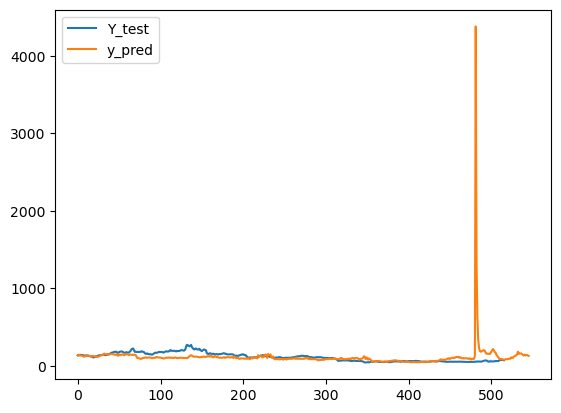

In [23]:
pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred']).plot()

In [24]:
pre_df.to_csv("../result/LSTM/ltc_NN.csv")

In [25]:

!kdeconnect-cli -n TAS-AN00 --ping-msg 'Script complete!'